<h1>EDA and ARIMA exploration of Web Traffic Data<h1>

<h3>Import libraries<h3>

In [ ]:
import pandas as pd
import numpy as np
import warnings
import scipy
from datetime import timedelta

<h3>Import libraries for forecasting with decomposable model<h3>

In [ ]:
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

<h3> Import libraries for visualisation<h3>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

<h3> Set plot style and ignore warnings<h3>

In [ ]:
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

<h3>Read data into memory</h3>

In [ ]:
train = pd.read_csv("C:/Users/matth/webtraffic/train_1.csv")

<h3>Convert data to transactional, change dates to datetime data type, create field indicating weekend</h3>

In [ ]:
train_flattened = pd.melt(train, id_vars='Page', var_name='date', value_name='Visits')
train_flattened['date'] = train_flattened['date'].astype('datetime64[ns]')
train_flattened['weekend'] = ((train_flattened.date.dt.dayofweek) // 5 == 1).astype(float)

<h3>Convert mean and median page visits and join to dataset</h3>

In [ ]:
df_median = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].median())
df_median.columns = ['median']
df_mean = pd.DataFrame(train_flattened.groupby(['Page'])['Visits'].mean())
df_mean.columns = ['mean']
train_flattened = train_flattened.set_index('Page').join(df_mean).join(df_median).reset_index(drop=False)

<h3>Add column for weekday, day, month and year</h3>

In [14]:
train_flattened['weekday'] = train_flattened['date'].dt.dayofweek
train_flattened['day'] = train_flattened['date'].dt.day
train_flattened['month'] = train_flattened['date'].dt.month
train_flattened['year'] = train_flattened['date'].dt.year

<h3>Plot of mean number of visits per page by date</h3>

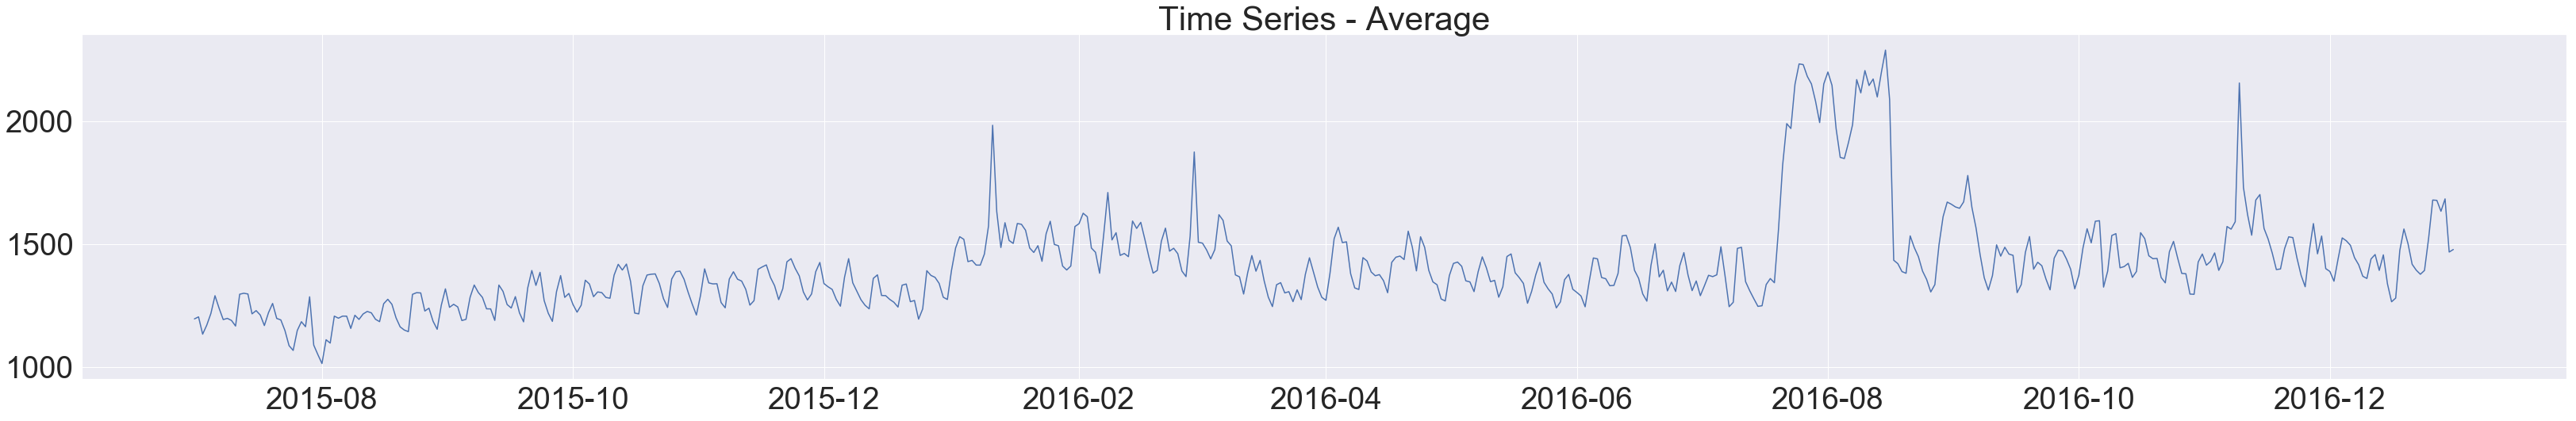

In [15]:
plt.figure(figsize=(50, 8))
mean_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].mean()
plt.plot(mean_group)
plt.title('Time Series - Average')
plt.show()

<h3>Plot of mean number of visits per page by date</h3>

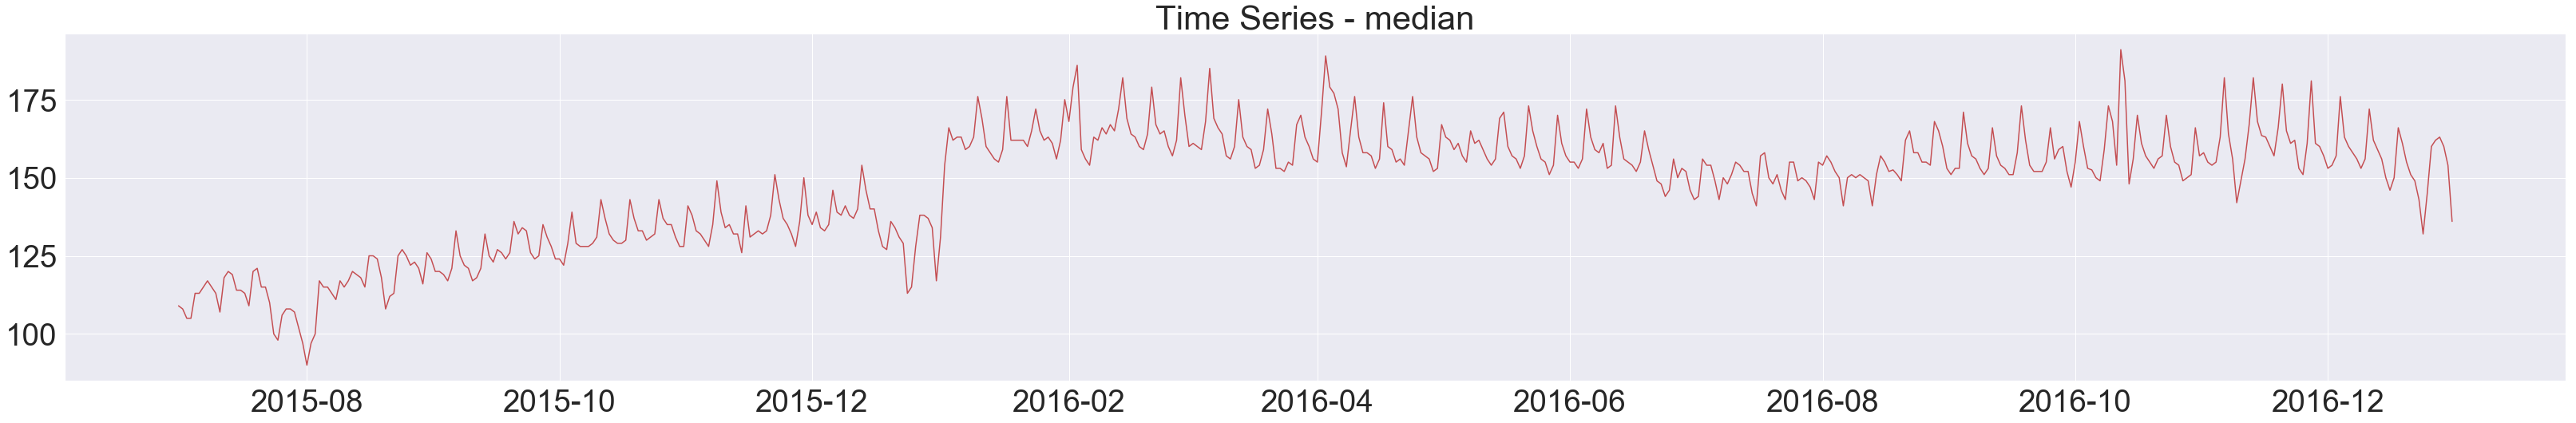

In [25]:
plt.figure(figsize=(50, 8))
median_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].median()
plt.plot(median_group, color = 'r')
plt.title('Time Series - median')
plt.show()

<h3>Plot of standard deviation number of visits per page by date</h3>

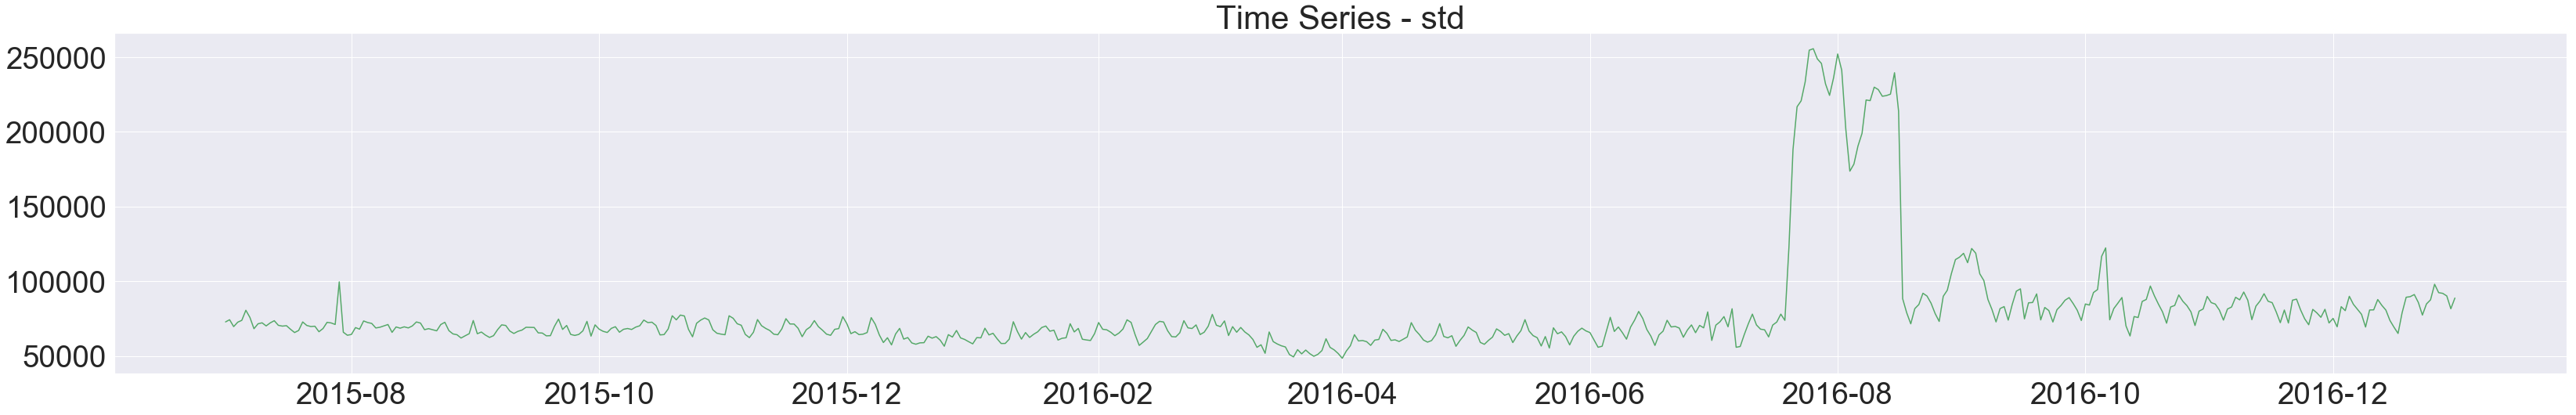

In [17]:
plt.figure(figsize=(50, 8))
std_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].std()
plt.plot(std_group, color = 'g')
plt.title('Time Series - std')
plt.show()

<h3>Create day of the week file with label</h3>

In [18]:
train_flattened['weekday_num'] = train_flattened['weekday']
train_flattened['weekday'].replace(0,'01 - Monday',inplace=True)
train_flattened['weekday'].replace(1,'02 - Tuesday',inplace=True)
train_flattened['weekday'].replace(2,'03 - Wednesday',inplace=True)
train_flattened['weekday'].replace(3,'04 - Thursday',inplace=True)
train_flattened['weekday'].replace(4,'05 - Friday',inplace=True)
train_flattened['weekday'].replace(5,'06 - Saturday',inplace=True)
train_flattened['weekday'].replace(6,'07 - Sunday',inplace=True)

<h3>Create dataframe for heatmap of day of the week by month</h3>

In [29]:
train_group = train_flattened.groupby(["month", "weekday"])['Visits'].mean().reset_index()
train_group = train_group.pivot('weekday','month','Visits').sort_index()

<h3>Draw heatmap of day of the week by month with average visits in each cell</h3>

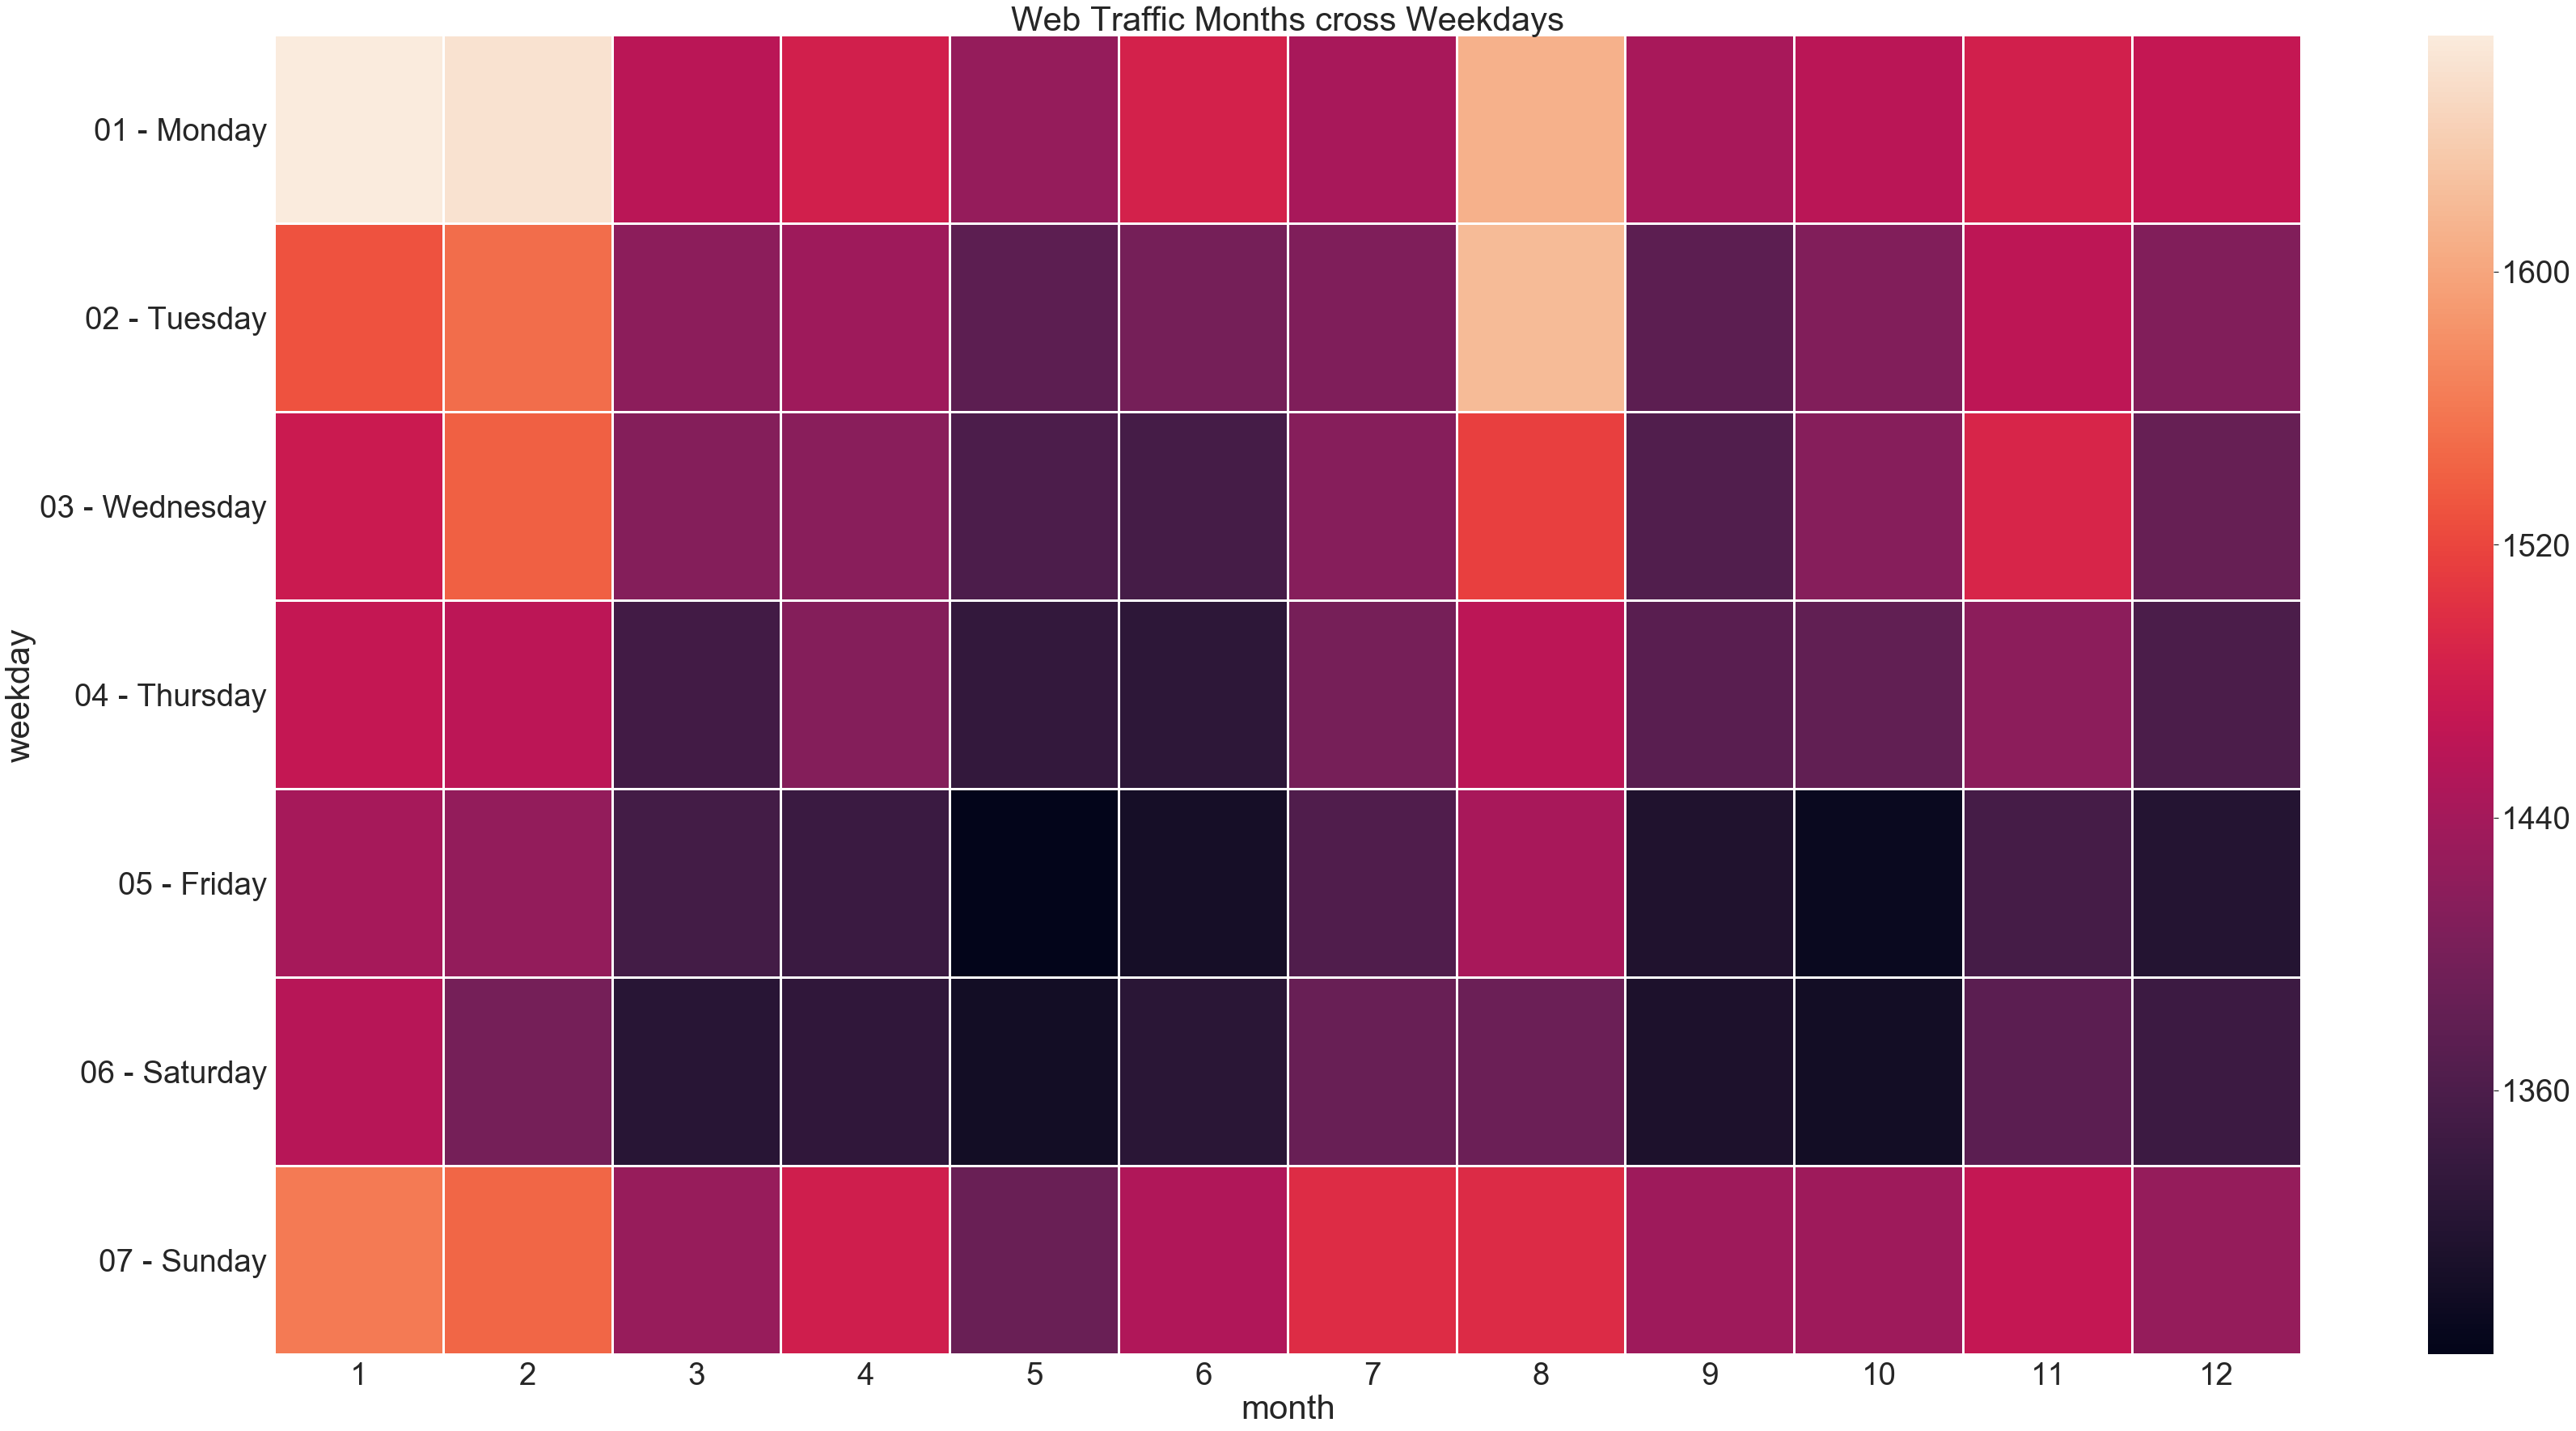

In [30]:
sns.set(font_scale=3.5) 
f, ax = plt.subplots(figsize=(50, 30))
sns.heatmap(train_group, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic Months cross Weekdays')
plt.show()

<h3>Create dataframe for heatmap of day of the month by month</h3>

In [ ]:
train_day = train_flattened.groupby(["month", "day"])['Visits'].mean().reset_index()
train_day = train_day.pivot('day','month','Visits').sort_index().dropna()

<h3>Draw heatmap of day of the month by month with average visits in each cell</h3>

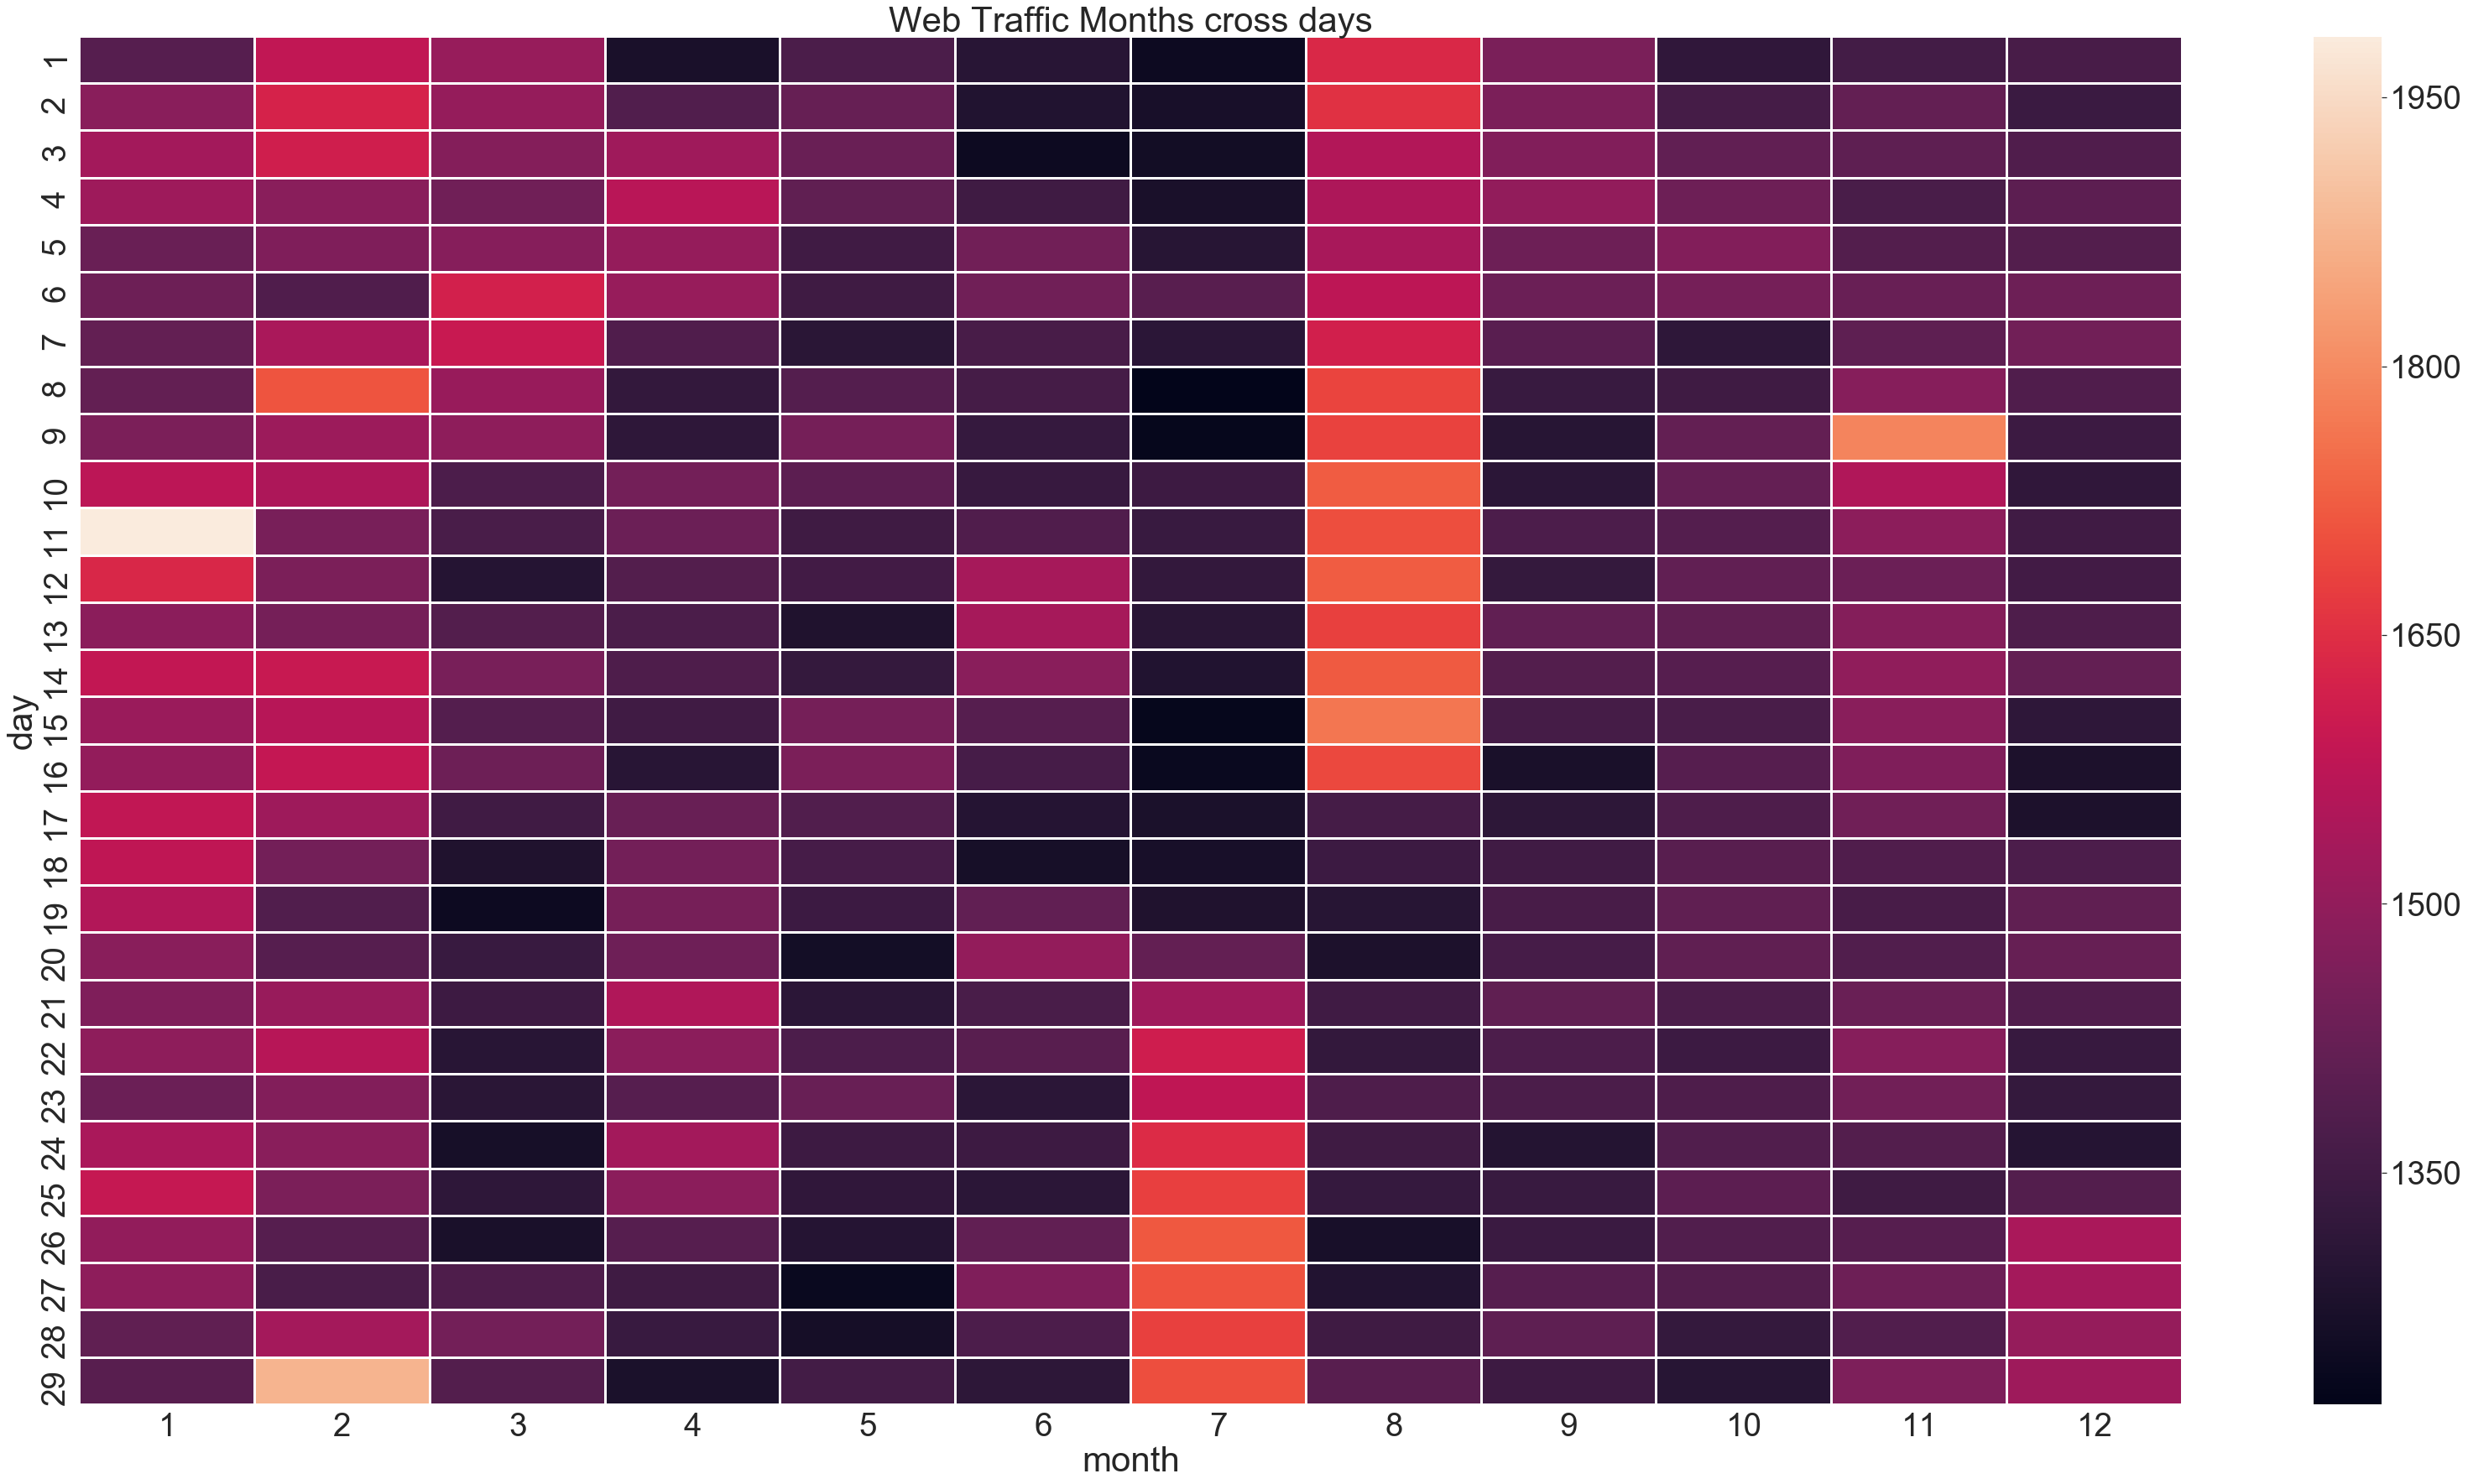

In [28]:
f, ax = plt.subplots(figsize=(50, 30))
sns.heatmap(train_day, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Web Traffic Months cross days')
plt.show()

<h3>Take mean_group dataframe and add weekday, day, month and year</h3>

In [33]:
times_series_means =  mean_group.reset_index(drop=False)
times_series_means['weekday'] = times_series_means['date'].dt.dayofweek
times_series_means['day'] = times_series_means['date'].dt.day
times_series_means['month'] = times_series_means['date'].dt.month
times_series_means['year'] = times_series_means['date'].dt.year

<h3>Create rolling, mean, median and standard deviation number of visits and perform Dickey-Fuller Test for stationarity</h3>

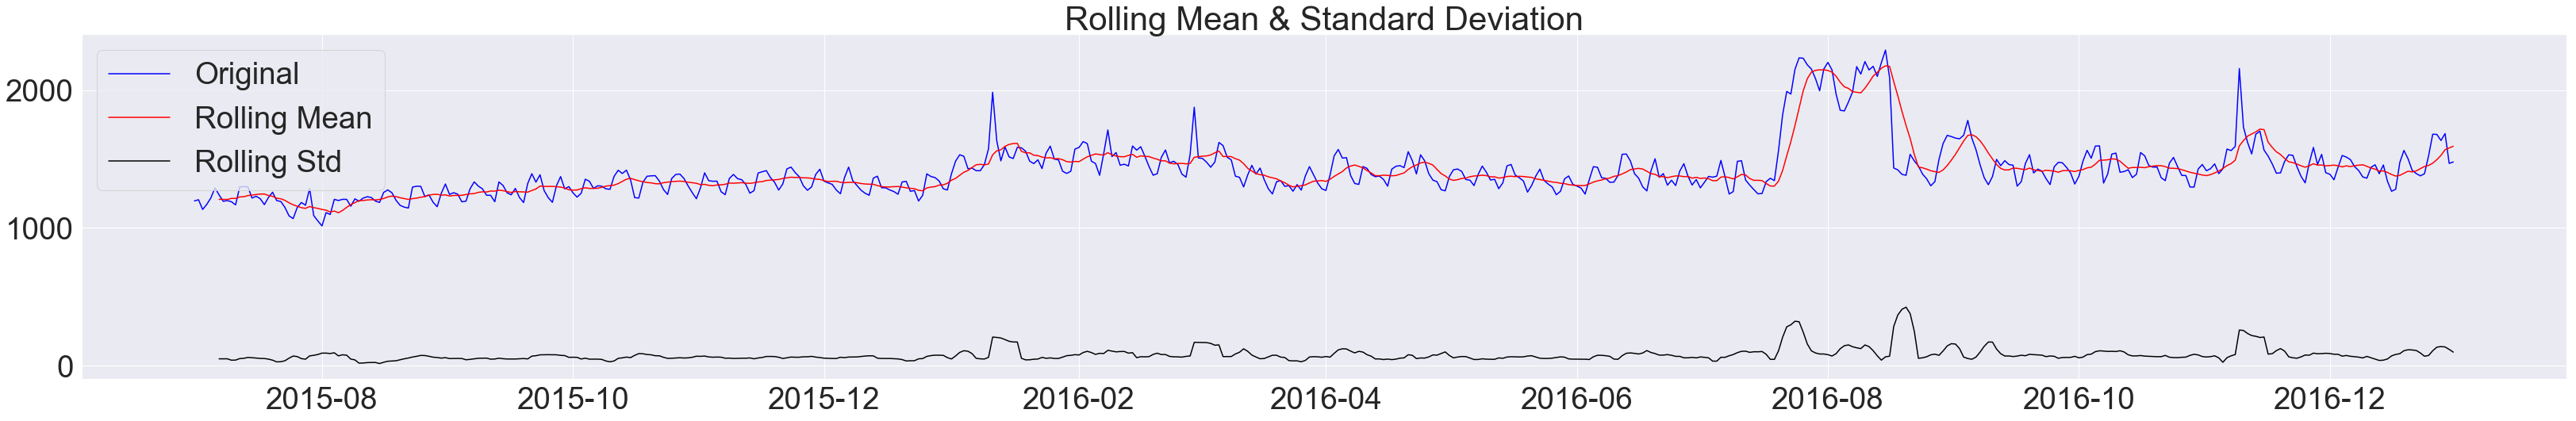

Results of Dickey-Fuller Test:
Test Statistic                  -2.870971
p-value                          0.048829
#Lags Used                      14.000000
Number of Observations Used    535.000000
Critical Value (1%)             -3.442632
Critical Value (5%)             -2.866957
Critical Value (10%)            -2.569655
dtype: float64


In [22]:
df_date_index = times_series_means[['date','Visits']].set_index('date')

def test_stationarity(timeseries):
    plt.figure(figsize=(50, 8))
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()

    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.adfuller(timeseries['Visits'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(df_date_index)   

<h3>Plot of trend over all data, seasonal trend and residuals</h3>

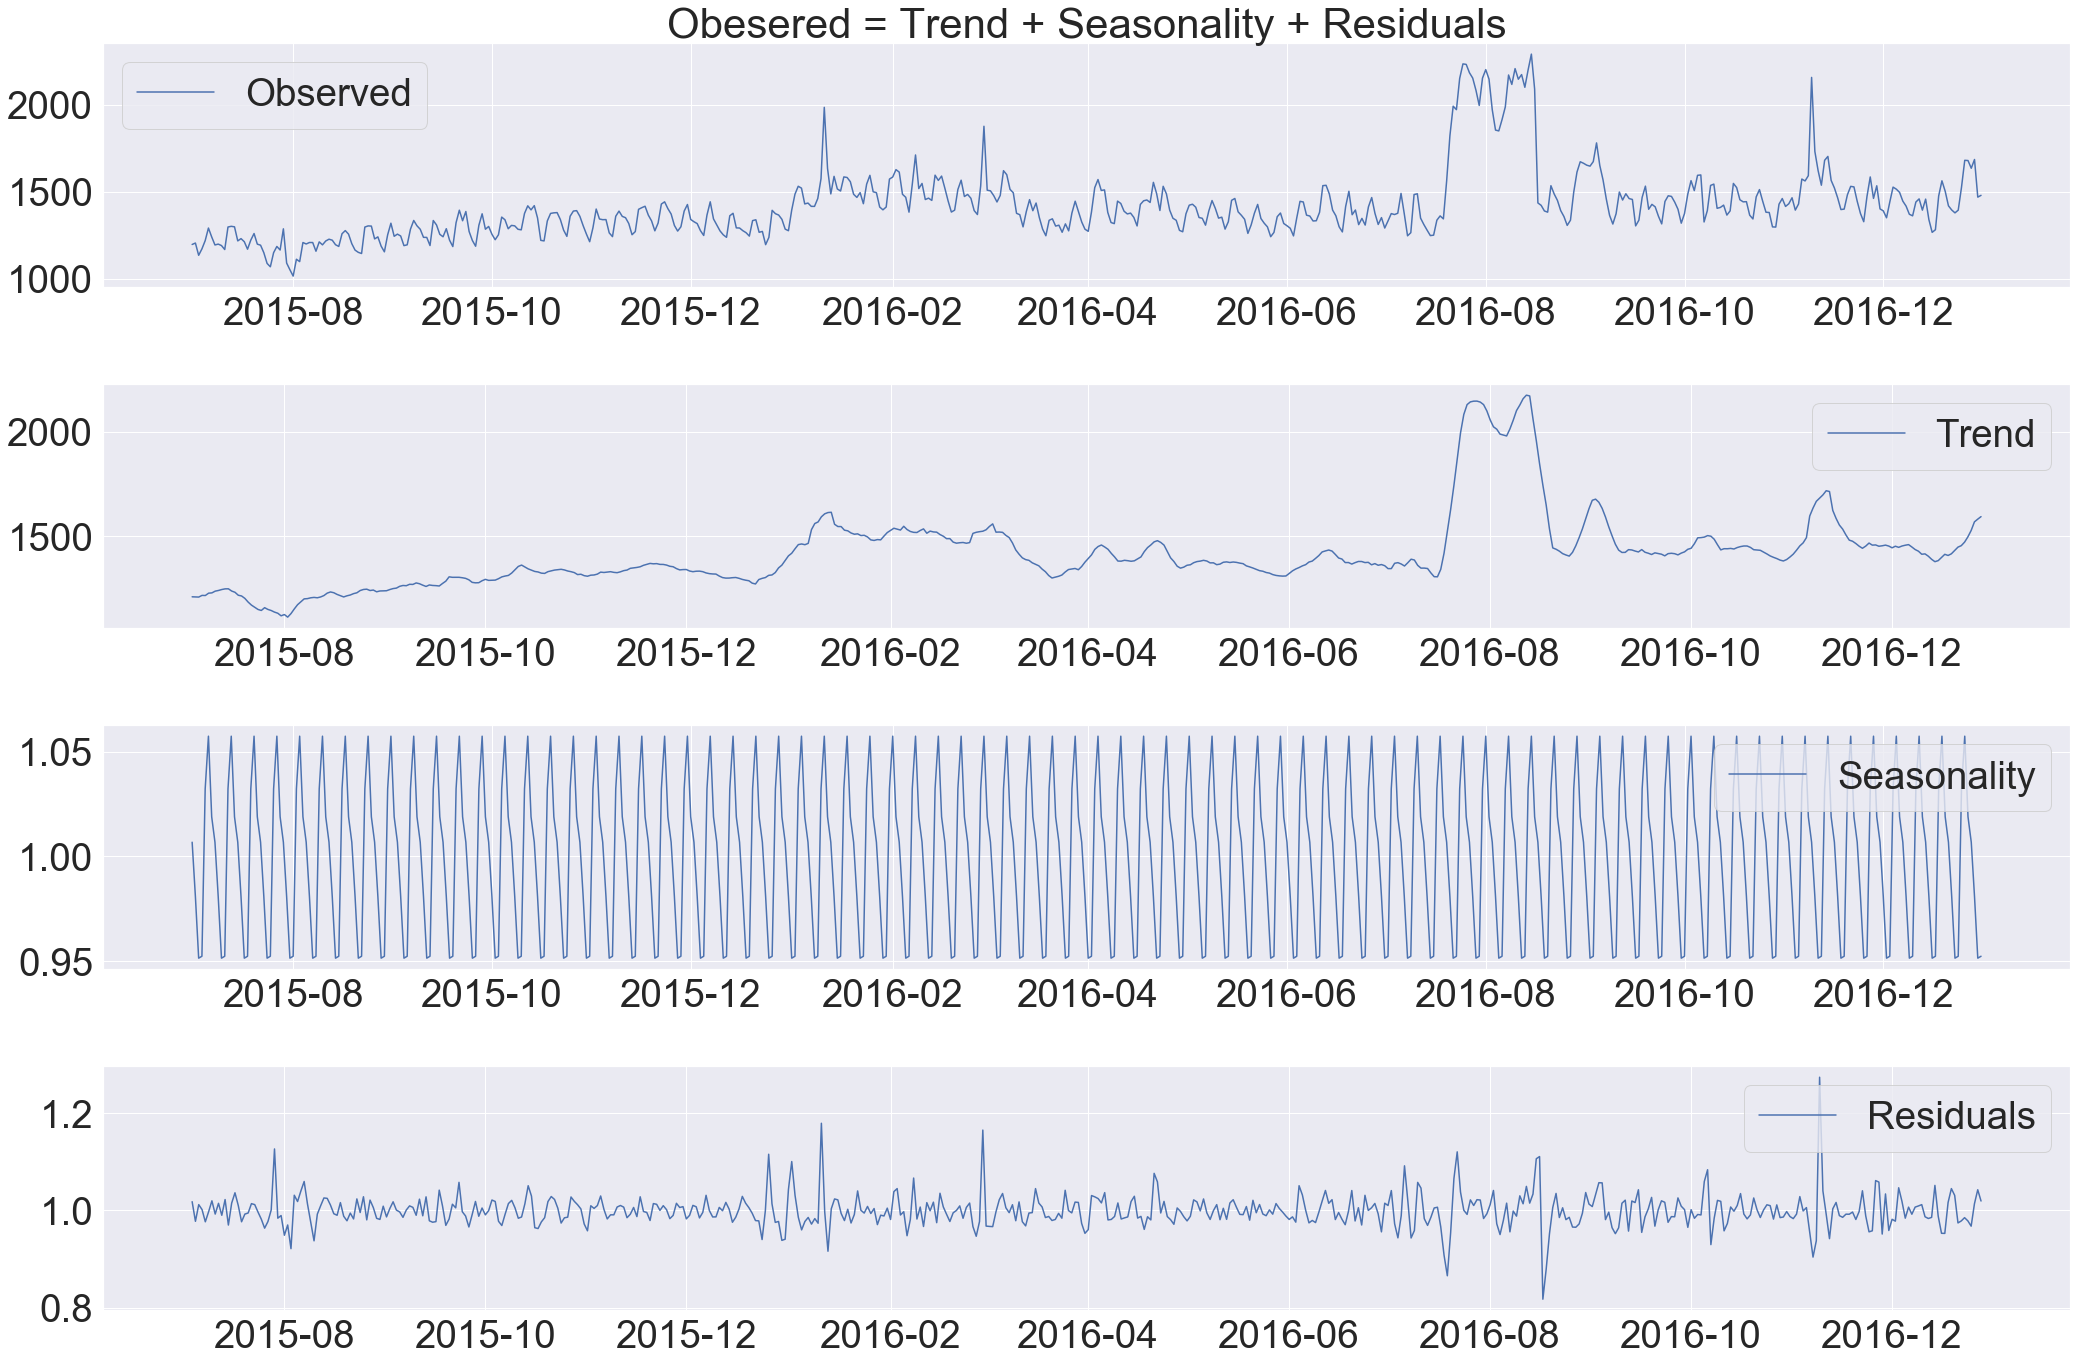

In [36]:
decomposition = sm.tsa.seasonal_decompose(df_date_index, model='multiplicative',freq = 7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
rcParams['figure.figsize'] = 30, 20

plt.subplot(411)
plt.title('Obesered = Trend + Seasonality + Residuals')
plt.plot(df_date_index, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()